## Process Synthetic Data with Aurora

This notebook shows how to process MTH5 data from a synthetic dataset.

Steps
1. Create the synthetic mth5
2. Get a Run Summary from the mth5
3. Select the station to process and optionally the remote reference station
4. Create a processing config
5. Generate TFs
6. Archive the TFs (in emtf_xml or z-file)

### Here are the modules we will need to import 

In [1]:
import pathlib
import warnings

from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.test_utils.synthetic.make_mth5_from_asc import create_test12rr_h5
from aurora.test_utils.synthetic.paths import DATA_PATH
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings('ignore')

2022-08-20 12:46:27,511 [line 135] mth5.setup_logger - INFO: Logging file can be found /home/kkappler/software/irismt/mth5/logs/mth5_debug.log


## Define mth5 file

The synthetic mth5 file is used for testing in `aurora/tests/synthetic/` and probably already exists on your system

In [2]:
mth5_path = DATA_PATH.joinpath("test12rr.h5")

But, if it doesn't or you want to re-make it, call `create_test12rr_h5()`

In [3]:
if not mth5_path.exists():
    create_test12rr_h5()   

## Get a Run Summary

In [4]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.mini_summary

2022-08-20 12:46:30,648 [line 744] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


,survey,station_id,run_id,start,end
0,none,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00
1,none,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00


## Define a Kernel Dataset


In [5]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "test1", "test2")
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end
0,none,test1,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00
1,none,test2,001,1980-01-01 00:00:00+00:00,1980-01-01 11:06:39+00:00


Note that we didn't need to explicitly open the mth5 to do that

## Now define the processing Configuration

The only things we need to provide are our band processing scheme, and the data sample rate.  Also, when doing only single station processing you need to specify RME processing (rather than remote reference processing which expects extra time series from another station)

In [6]:
cc = ConfigCreator()
config = cc.create_run_processing_object(emtf_band_file=BANDS_DEFAULT_FILE,
                                    sample_rate=1.0
                                    )
config.stations.from_dataset_dataframe(kernel_dataset.df)
for decimation in config.decimations:
    decimation.estimator.engine = "RME"

## Call process_mth5

Processing config indicates 4 decimation levels 
Processing band 25.728968s
Processing band 19.929573s
Processing band 15.164131s
Processing band 11.746086s
Processing band 9.195791s
Processing band 7.362526s
Processing band 5.856115s
Processing band 4.682492s
GET PLOTTER FROM MTpy


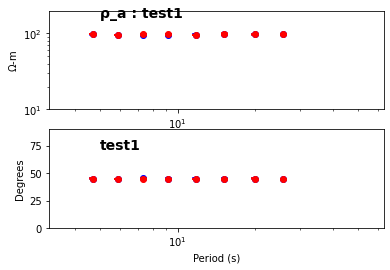

Processing band 102.915872s
Processing band 85.631182s
Processing band 68.881694s
Processing band 54.195827s
Processing band 43.003958s
Processing band 33.310722s
GET PLOTTER FROM MTpy


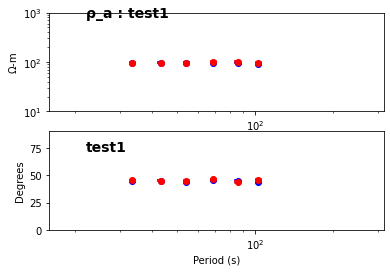

Processing band 411.663489s
Processing band 342.524727s
Processing band 275.526776s
Processing band 216.783308s
Processing band 172.015831s
Processing band 133.242890s
GET PLOTTER FROM MTpy


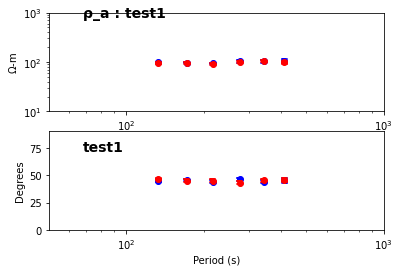

Processing band 1514.701336s
Processing band 1042.488956s
Processing band 723.371271s
Processing band 532.971560s
Processing band 412.837995s
GET PLOTTER FROM MTpy


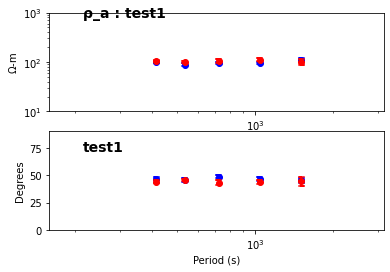

WARN: Need test for multiple mth5 objs for non-tf_collection output
WARN: Also need to add handling of 0.1.0 vs 0.2.0 mth5 file_version


2022-08-20 12:46:44,226 [line 744] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5
2022-08-20 12:46:44,227 [line 744] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing /home/kkappler/software/irismt/aurora/tests/synthetic/data/test12rr.h5


In [7]:
show_plot = True
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=None,
                    return_collection=False
                )

In [8]:
xml_file_base = f"synthetic_test1.xml"
tf_cls.write_tf_file(fn=xml_file_base, file_type="emtfxml")


2022-08-20 12:46:44,321 [line 197] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote synthetic_test1.xml


EMTFXML(station='test1', latitude=0.00, longitude=0.00, elevation=0.00)